In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [ ]:
# Load the MNIST dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])  # Convert labels to integers

digit_indices = {digit: (y == digit) for digit in range(10)}
digit_data = {digit: X[digit_indices[digit]] for digit in range(10)}

# Assign datasets for each digit to x1, x2, ..., x10
x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [digit_data[digit] for digit in range(10)]


Xtrain = np.concatenate((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10),axis=0)
ytrain = np.concatenate([
    np.full(x1.shape[0], 0),
    np.full(x2.shape[0], 1),
    np.full(x3.shape[0], 2),
    np.full(x4.shape[0], 3),
    np.full(x5.shape[0], 4),
    np.full(x6.shape[0], 5),
    np.full(x7.shape[0], 6),
    np.full(x8.shape[0], 7),
    np.full(x9.shape[0], 8),
    np.full(x10.shape[0], 9),
])

with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)


# Split the data to training, testing, and validation subsets

In [ ]:
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/3, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

print(f"Number of samples in training set: {Nsamples}")
print(f"Number of features: {Nfeatures}")


Number of samples in training set: 16333
Number of features: 784


# Accuracy of a classifier

## Define and test gaussianClassifierWithIdentityCovariance

In [ ]:
classes = np.unique(ytrain)
n_classes = len(classes)
n_features = Xtrain.shape[1]

# Initialize A1 to store discriminant parameters
A1 = np.zeros((n_features + 1, n_classes))
A1 #(785*10)
for i, c in enumerate(classes):
    # Extract data for the current class
    X_c = Xtrain[ytrain == c]

    mu_i = np.mean(X_c, axis=0)

    a_i = mu_i

    b_i = -0.5 * np.dot(mu_i, mu_i)

    A1[:, i] = np.append(a_i, b_i)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

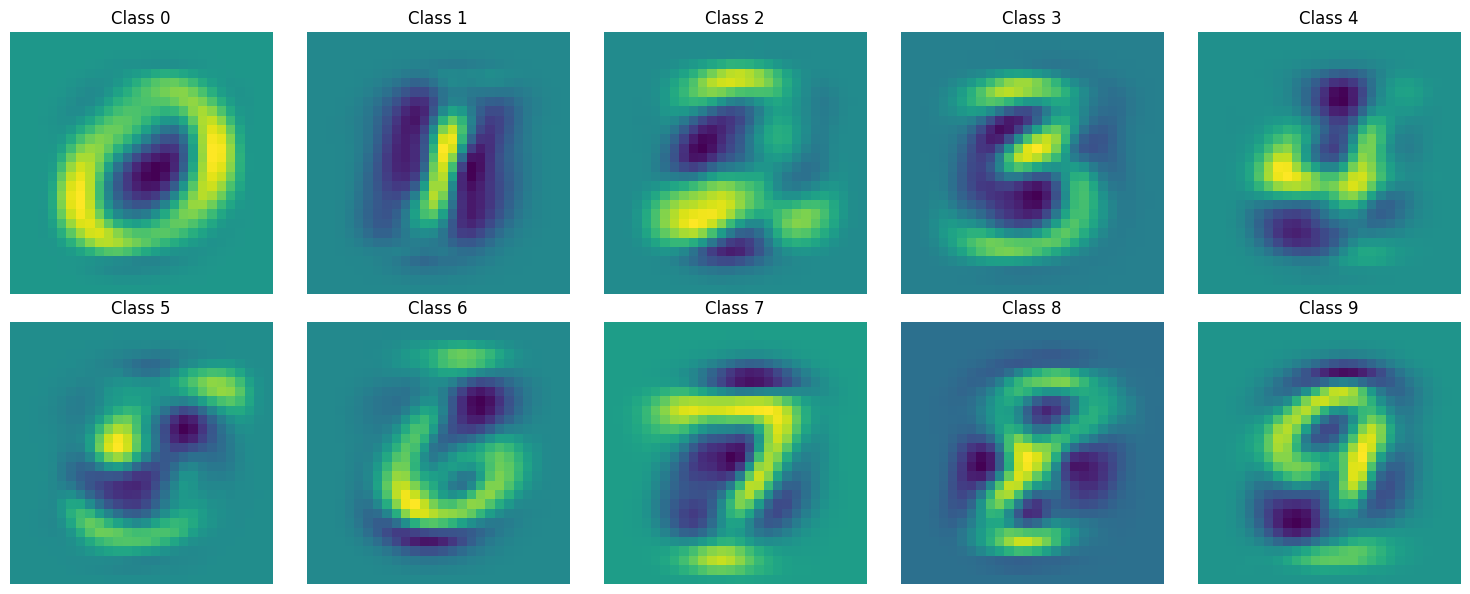

In [ ]:
def gaussianMultiChannelClassifier(Xtrain, ytrain):

    unique_classes = np.unique(ytrain)
    n_classes = len(unique_classes)
    n_features = Xtrain.shape[1]

    A1 = np.zeros((n_features + 1, n_classes))

    class_means = []
    for cls in unique_classes:
        class_data = Xtrain[ytrain == cls]
        class_mean = np.mean(class_data, axis=0)
        class_means.append(class_mean)

    for i, cls in enumerate(unique_classes):
        other_means = np.array([m for j, m in enumerate(class_means) if j != i])
        mean_diff = class_means[i] - np.mean(other_means, axis=0)

        bias = -0.5 * np.dot(class_means[i], mean_diff)

        discriminant = np.concatenate([mean_diff, [bias]])

        A1[:, i] = discriminant

    return A1


A1 = gaussianMultiChannelClassifier(X_train, y_train)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    weights = A1[0:784, i]
    axes[i].imshow(np.reshape(weights, (28, 28)), cmap='viridis')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

Predicting with A1

## Define and test logisticRegressionMultiClassClassifier

---



---



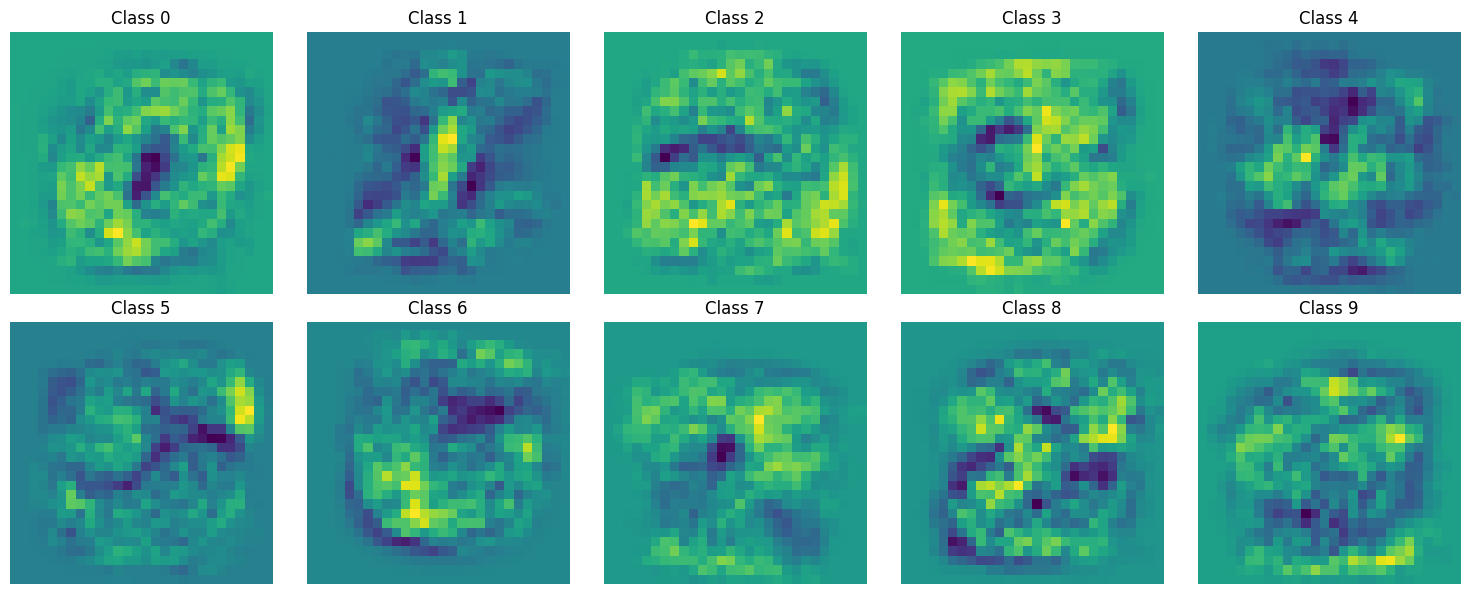

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from scipy.special import softmax

def logisticRegressionMultiClassClassifier(Xtrain, ytrain, num_classes=10, iterations=500, step_size=1e-3, verbose=False):

    # Add bias term to the training data
    X_bias = np.c_[Xtrain, np.ones(Xtrain.shape[0])]
    n_samples, n_features = X_bias.shape

    encoder = OneHotEncoder(sparse_output=False)
    Y_one_hot = encoder.fit_transform(ytrain.reshape(-1, 1))

    A2 = 0.01 * np.random.randn(n_features, num_classes) / np.sqrt(n_features)

    for i in range(iterations):
        Z = np.dot(X_bias, A2)

        probabilities = softmax(Z,axis=1)

        gradient = np.dot(X_bias.T, (probabilities - Y_one_hot))

        A2 -= step_size * gradient

    return A2


A2 = logisticRegressionMultiClassClassifier(X_train, y_train, verbose=True)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    weights = A2[0:784, i]
    axes[i].imshow(np.reshape(weights, (28, 28)), cmap='viridis')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

logisticRegressionMultiClassClassifierWithRegularization

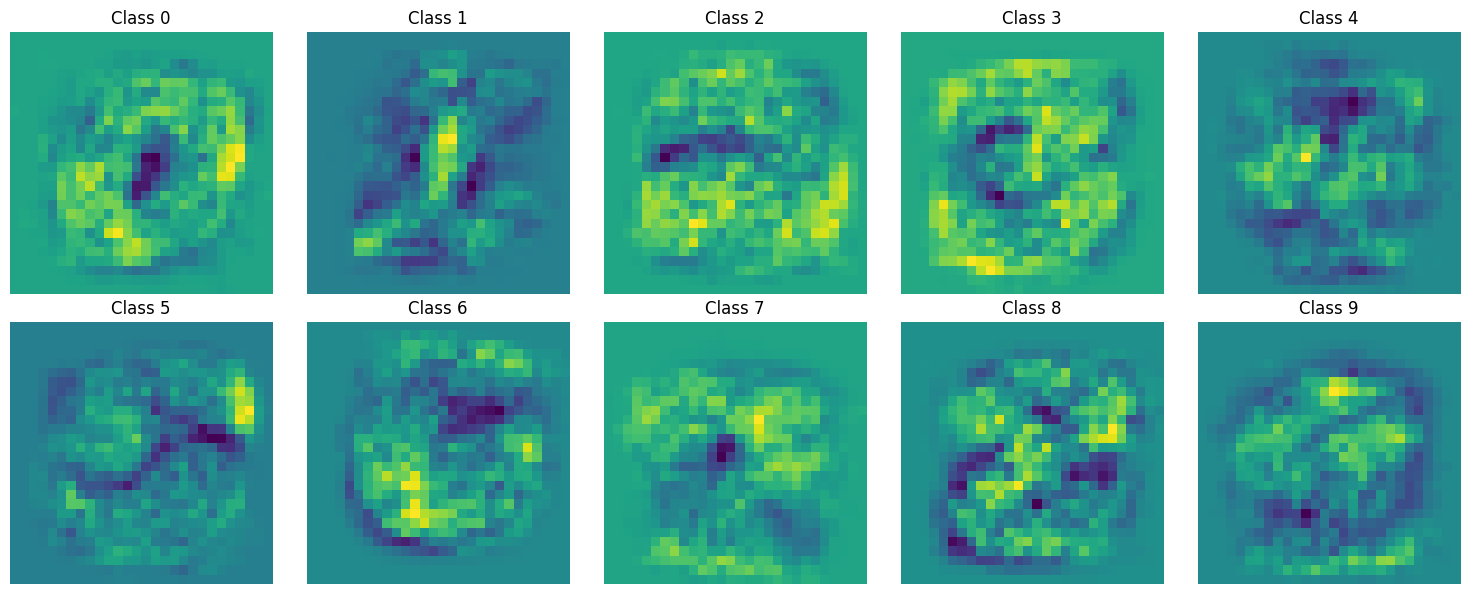

In [ ]:
import numpy as np
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder

def logisticRegressionMultiClassClassifierWithRegularization(Xtrain, ytrain, lam, num_classes=10, iterations=500, step_size=1e-3, verbose=False):

    Xtilde = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))
    n_samples, n_features = Xtilde.shape

    encoder = OneHotEncoder(sparse_output=False)
    Y_one_hot = encoder.fit_transform(ytrain.reshape(-1, 1))

    A3 = 0.01 * np.random.randn(n_features, num_classes) / np.sqrt(n_features)

    for i in range(iterations):

        Z = np.dot(Xtilde, A3)

        probabilities = softmax(Z, axis=1)

        gradient = np.dot(Xtilde.T, (probabilities - Y_one_hot))

        gradient[:, :-1] += 2 * lam * A3[:, :-1]

        A3 -= step_size * gradient

    return A3


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
A3 = logisticRegressionMultiClassClassifierWithRegularization(
    X_train, y_train, lam=0.001, verbose=True
)
for i in range(10):
    weights = A3[0:784, i]
    axes[i].imshow(np.reshape(weights, (28, 28)), cmap='viridis')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Optimize_MC_Hyperparameters

Testing λ = 0.001
Testing λ = 0.01
Testing λ = 0.1
Testing λ = 1
Testing λ = 10
Testing λ = 100
Optimal λ: 0.1, Validation Accuracy: 90.36%


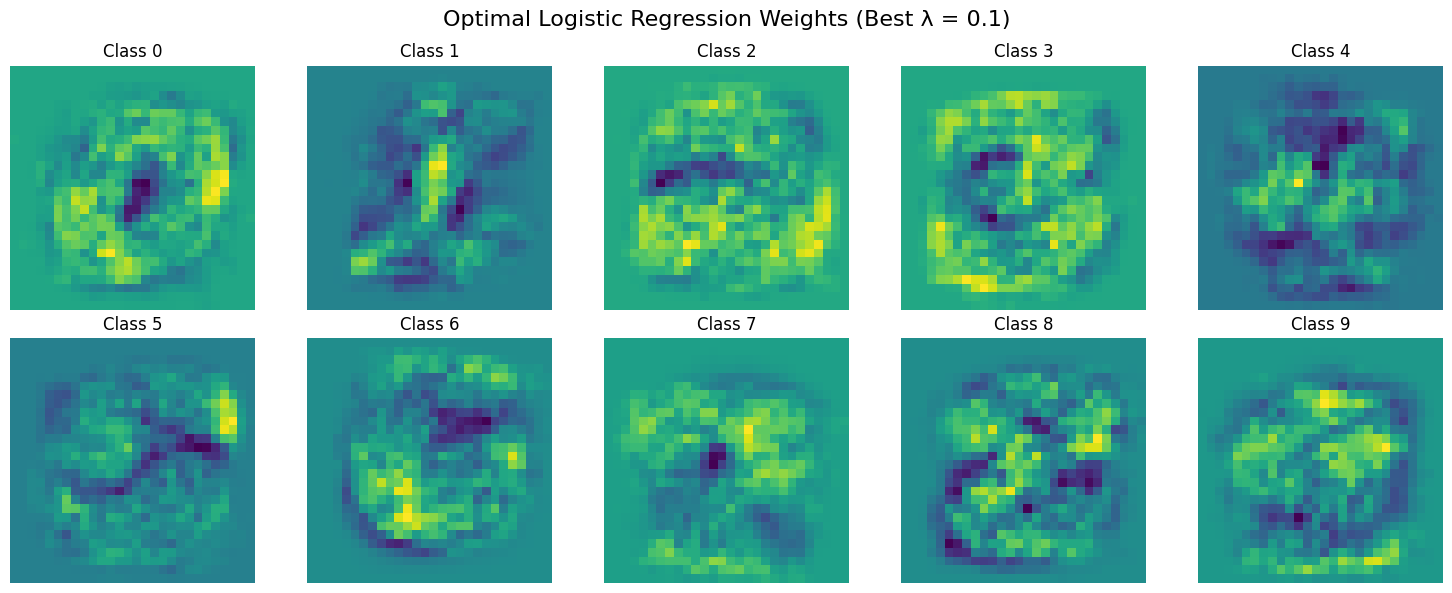

In [ ]:
import numpy as np

def Optimize_MC_Hyperparameters(Xtrain, ytrain, Xval, yval, lam_values, iterations=500, step_size=1e-3, verbose=False):

    best_lambda = None
    best_accuracy = 0
    best_A4 = None

    for lam in lam_values:
        if verbose:
            print(f"Testing λ = {lam}")

        A3 = logisticRegressionMultiClassClassifierWithRegularization(
            Xtrain, ytrain, lam=lam, iterations=iterations, step_size=step_size, verbose=False
        )

        y_pred = predict_multiclass_regularized(Xval, A3)

        accuracy = np.mean(y_pred == yval) * 100

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lambda = lam
            best_A4 = A3

    if verbose:
        print(f"Optimal λ: {best_lambda}, Validation Accuracy: {best_accuracy:.2f}%")

    return best_lambda, best_A4

def predict_multiclass_regularized(X, A3):

    Xtilde = np.hstack((X, np.ones((X.shape[0], 1))))  # Augmented input with bias
    probabilities = softmax(np.dot(Xtilde, A3), axis=1)
    return np.argmax(probabilities, axis=1)



lam_values = [0.001, 0.01, 0.1, 1, 10, 100]

best_lambda, A4 = Optimize_MC_Hyperparameters(
    X_train, y_train, X_val, y_val, lam_values, iterations=500, step_size=1e-3, verbose=True
)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):  # Loop over classes 0 to 9
    weights = A4[0:784, i]  # Extract weights for class `i`
    axes[i].imshow(np.reshape(weights, (28, 28)), cmap='viridis')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle(f"Optimal Logistic Regression Weights (Best λ = {best_lambda})", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
X_bias = np.c_[X_test, np.ones(X_test.shape[0])]

misclassified = 0

for i in range(10):
    prediction = np.dot(X_bias[y_test==i], A1[:,i])

    prediction[prediction >= 0] = i
    prediction[prediction < 0] = -10
    # predicted_label = predicted_label.astype(int)

    true_label = y_test[y_test == i]
    misclassified_label = np.sum(prediction != true_label)

    # Add to total misclassifications
    misclassified += misclassified_label

In [ ]:
import numpy as np

def testLinearMCClassifier(A, X, y):

    X_bias = np.c_[X, np.ones(X.shape[0])]

    misclassified = 0

    for i in range(10):
        prediction = np.dot(X_bias[y==i], A[:,i])

        prediction[prediction >= 0] = i
        prediction[prediction < 0] = -10

        true_label = y[y == i]
        misclassified_label = np.sum(prediction != true_label)

        # Add to total misclassifications
        misclassified += misclassified_label

    # Calculate and print accuracy
    total_samples = len(y)
    accuracy_percent = 100 - (misclassified / total_samples) * 100
    print(f"Mis-classifications= {misclassified} out of {total_samples}, Accuracy percent is given by: {accuracy_percent:.2f} %")
    return misclassified





# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [ ]:
def compareClassifiers(X_train, y_train, X_val, y_val, X_test, y_test, iterations=500, step_size=1e-4, lam=0.1):

    print("Training and evaluating classifiers...\n")
    print("Gaussian Multi-Channel Classifier (A1): ")
    A1 = gaussianMultiChannelClassifier(X_train, y_train)
    test_misclassifications_A1 = testLinearMCClassifier(A1, X_test, y_test)

    print("\nLogistic Regression Multi-Class Classifier (A2): ")
    A2 = logisticRegressionMultiClassClassifier(X_train, y_train, verbose=True)
    test_misclassifications_A2 = testLinearMCClassifier(A2, X_test, y_test)

    print("\nRegularized Logistic Regression Multi-Class Classifier (A3): ")
    A3 = logisticRegressionMultiClassClassifierWithRegularization(
        X_train, y_train, lam=0.001, verbose=True
    )
    test_misclassifications_A3 = testLinearMCClassifier(A3, X_test, y_test)

    print("\nOptimized Regularized Logistic Regression Multi-Class Classifier (A4): ")
    best_lambda, A4 = Optimize_MC_Hyperparameters(
        X_train, y_train, X_val, y_val, lam_values, iterations=500, step_size=1e-3, verbose=True
    )
    test_misclassifications_A4 = testLinearMCClassifier(A4, X_test, y_test)


    # Summary
    print("\nSummary of Test Misclassifications:")
    print(f"Gaussian with Identity Covariance: {test_misclassifications_A1}")
    print(f"Logistic Regression Multi-Class Classifier: {test_misclassifications_A2}")
    print(f"Logistic Regression with Regularization (λ={lam}): {test_misclassifications_A3}")
    print(f"Logistic Regression Multi-Class Classifier: {test_misclassifications_A4}")

compareClassifiers(X_train, y_train, X_val, y_val, X_test, y_test, iterations=500, step_size=1e-4, lam=0.1)


Training and evaluating classifiers...

Gaussian Multi-Channel Classifier (A1): 
Mis-classifications= 2707 out of 21000, Accuracy percent is given by: 87.11 %

Logistic Regression Multi-Class Classifier (A2): 
Mis-classifications= 113 out of 21000, Accuracy percent is given by: 99.46 %

Regularized Logistic Regression Multi-Class Classifier (A3): 
Mis-classifications= 119 out of 21000, Accuracy percent is given by: 99.43 %

Optimized Regularized Logistic Regression Multi-Class Classifier (A4): 
Testing λ = 0.001
Testing λ = 0.01
Testing λ = 0.1
Testing λ = 1
Testing λ = 10
Testing λ = 100
Optimal λ: 0.1, Validation Accuracy: 90.30%
Mis-classifications= 121 out of 21000, Accuracy percent is given by: 99.42 %

Summary of Test Misclassifications:
Gaussian with Identity Covariance: 2707
Logistic Regression Multi-Class Classifier: 113
Logistic Regression with Regularization (λ=0.1): 119
Logistic Regression Multi-Class Classifier: 121
